In [48]:
import pandas as pd
df = pd.read_csv("/content/winemag-data_first150k.csv")

def display_dataset(dataset):
    for index, row in dataset.iterrows():
        print(f"Data {index}:")
        for column, value in row.items():
            print(f"  {column}: {value}")
        print("-")

display_dataset(df)

Streaming output truncated to the last 5000 lines.
  points: 82
  price: 13.0
  province: California
  region_1: Sonoma County
  region_2: Sonoma
  variety: Chardonnay
  winery: Gan Eden
-
Data 150546:
  no: 150546
  country: US
  description: Strong mint and menthol aromatics give way to intense fresh-cut cedar flavors. There's just too much wood for this woodchuck to chuck.
  designation: nan
  points: 82
  price: 18.0
  province: New York
  region_1: North Fork of Long Island
  region_2: Long Island
  variety: Merlot
  winery: Hargrave
-
Data 150547:
  no: 150547
  country: France
  description: Herb and mineral aromas and flavors prevail in this dry, light-to-medium-weight sparkler. It has decent texture, but the flavors bear a medicinal quality ending with a slight bitterness.
  designation: Blanc de Blancs
  points: 82
  price: 15.0
  province: Alsace
  region_1: Alsace
  region_2: nan
  variety: Champagne Blend
  winery: Royale NV Brut
-
Data 150548:
  no: 150548
  country: US
 

In [52]:
import pandas as pd
df = pd.read_csv("/content/winemag-data_first150k.csv")

df['price'].fillna(df['price'].median(), inplace=True)
df['region_2'] = df['region_2'].fillna(df['region_1'])
df['region_1'] = df['region_1'].fillna(df['province'])
df['designation'] = df['designation'].fillna(df['variety'])

def display_dataset(dataset):
    for index, row in dataset.iterrows():
        print(f"Data {index}:")
        for column, value in row.items():
            print(f"  {column}: {value}")
        print("-")

display_dataset(df)

<ipython-input-52-ca822cb11572>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price'].fillna(df['price'].median(), inplace=True)


Streaming output truncated to the last 5000 lines.
  points: 82
  price: 13.0
  province: California
  region_1: Sonoma County
  region_2: Sonoma
  variety: Chardonnay
  winery: Gan Eden
-
Data 150546:
  no: 150546
  country: US
  description: Strong mint and menthol aromatics give way to intense fresh-cut cedar flavors. There's just too much wood for this woodchuck to chuck.
  designation: Merlot
  points: 82
  price: 18.0
  province: New York
  region_1: North Fork of Long Island
  region_2: Long Island
  variety: Merlot
  winery: Hargrave
-
Data 150547:
  no: 150547
  country: France
  description: Herb and mineral aromas and flavors prevail in this dry, light-to-medium-weight sparkler. It has decent texture, but the flavors bear a medicinal quality ending with a slight bitterness.
  designation: Blanc de Blancs
  points: 82
  price: 15.0
  province: Alsace
  region_1: Alsace
  region_2: Alsace
  variety: Champagne Blend
  winery: Royale NV Brut
-
Data 150548:
  no: 150548
  country

In [17]:
import pandas as pd
df = pd.read_csv("/content/winemag-data_first150k.csv")

df['price'].fillna(df['price'].median(), inplace=True)
df['region_2'] = df['region_2'].fillna(df['region_1'])
df['region_1'] = df['region_1'].fillna(df['province'])
df['designation'] = df['designation'].fillna(df['variety'])

df.to_csv('winemag_save.csv', index=False)

<ipython-input-17-dfa64040fa0d>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price'].fillna(df['price'].median(), inplace=True)


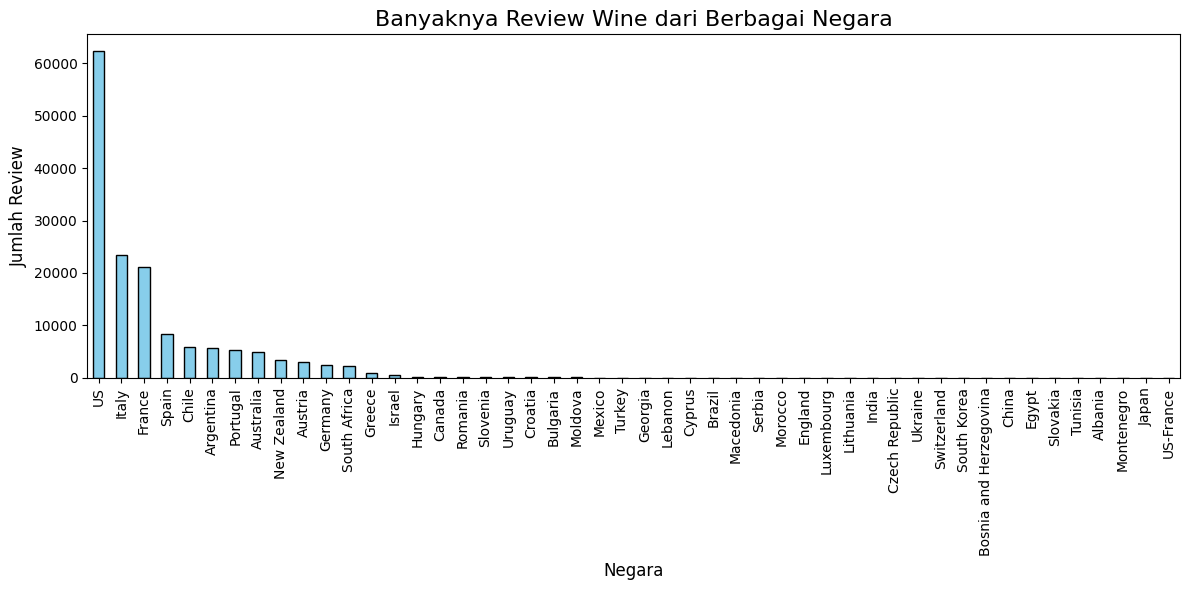

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('winemag_save.csv')

review_negara = df['country'].value_counts()

plt.figure(figsize=(12, 6))
review_negara.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Banyaknya Review Wine dari Berbagai Negara', fontsize=16)
plt.xlabel('Negara', fontsize=12)
plt.ylabel('Jumlah Review', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [37]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when

spark = SparkSession.builder.appName('Wine Quality Classification').getOrCreate()

df = spark.read.csv("/content/winemag_save.csv", header=True, inferSchema=True)

df = df.withColumn('quality_category',
                   when(col('points') < 80, 0)
                   .when(col('points') < 90, 1)
                   .otherwise(2))

country_indexer = StringIndexer(inputCol='country', outputCol='country_index', handleInvalid='skip')
variety_indexer = StringIndexer(inputCol='variety', outputCol='variety_index', handleInvalid='skip')

country_encoder = OneHotEncoder(inputCol='country_index', outputCol='country_vec')
variety_encoder = OneHotEncoder(inputCol='variety_index', outputCol='variety_vec')

assembler = VectorAssembler(inputCols=['country_vec', 'variety_vec'], outputCol='features')

lr = LogisticRegression(featuresCol='features', labelCol='quality_category')

pipeline = Pipeline(stages=[country_indexer, variety_indexer,
                            country_encoder, variety_encoder,
                            assembler, lr])

model = pipeline.fit(df)

predictions = model.transform(df)

predictions.select('quality_category', 'prediction').show(1000)

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='quality_category', predictionCol='prediction', metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy}')

evaluator_f1 = MulticlassClassificationEvaluator(labelCol='quality_category', predictionCol='prediction', metricName='f1')
f1_score = evaluator_f1.evaluate(predictions)
print(f'F1-Score: {f1_score}')

+----------------+----------+
|quality_category|prediction|
+----------------+----------+
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       2.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       2.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       2.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|               2|       1.0|
|         

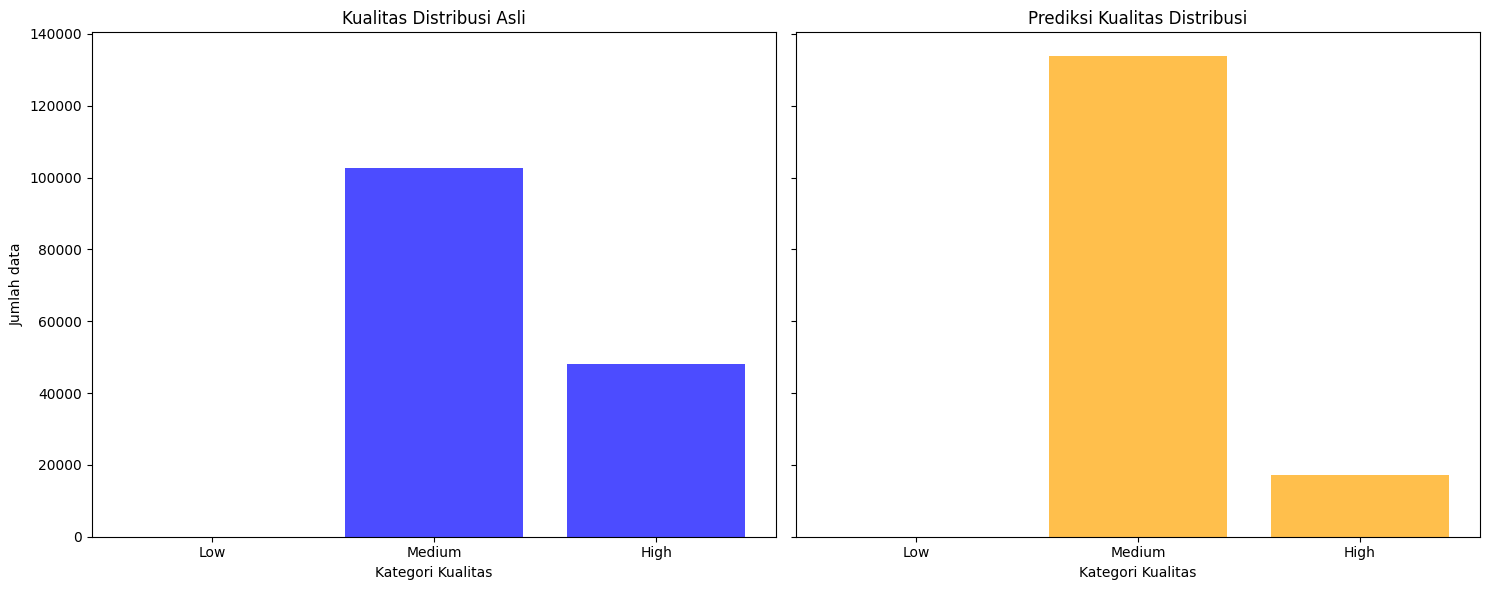

Accuracy: 0.69
F1-Score: 0.64


In [51]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

predictions_output = predictions.select('quality_category', 'prediction').toPandas()

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

actual_counts = predictions_output['quality_category'].value_counts().sort_index()
axes[0].bar(actual_counts.index, actual_counts.values, color='blue', alpha=0.7)
axes[0].set_title('Kualitas Distribusi Asli')
axes[0].set_xlabel('Kategori Kualitas')
axes[0].set_ylabel('Jumlah data')
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(["Low", "Medium", "High"])

predicted_counts = predictions_output['prediction'].value_counts().sort_index()
axes[1].bar(predicted_counts.index, predicted_counts.values, color='orange', alpha=0.7)
axes[1].set_title('Prediksi Kualitas Distribusi')
axes[1].set_xlabel('Kategori Kualitas')
axes[1].set_xticks([0, 1, 2])
axes[1].set_xticklabels(["Low", "Medium", "High"])

plt.tight_layout()
plt.show()

print(f"Accuracy: {accuracy:.2f}")
print(f"F1-Score: {f1_score:.2f}")
